# Copyright
<pre>
Jelen forráskód a Budapesti Műszaki és Gazdaságtudományi Egyetemen 
tartott "Deep Learning a gyakorlatban Python és LUA alapon" tantárgy segédanyagaként készült.

A tantárgy honlapja: http://smartlab.tmit.bme.hu/oktatas-deep-learning
Deep Learning kutatás: http://smartlab.tmit.bme.hu/deep-learning

A forráskódot GPLv3 licensz védi. Újrafelhasználás esetén lehetőség szerint kérejük az alábbi szerzőt értesíteni.

2020 (c) Gyires-Tóth Bálint (toth.b kukac tmit pont bme pont hu), Zainkó Csaba
</pre>

Jelen notebook egy példakódot mutat be egy dimenziós konvolúció alapú szekvenciális adat modellezésre. A példakód elsődlegesen az 1D konvolúcióra koncentrál, az általános megfontolások (standardizálás, min-max skálázás, early stopping, regularizáció, stb.) itt nem szerepelnek, de éles feladatokban szükségszerűek. 

In [2]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, LSTM
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt

Az LSTM réteg létrehozása.

In [5]:
def make_lstm(window_size, lstm_size, nb_input_series=1, nb_outputs=1):
    model = Sequential()
    model.add(LSTM(lstm_size, input_shape=(window_size, nb_input_series)))
    model.add(Flatten())
    model.add(Dense(nb_outputs, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model

Az idősor adatokból az egy dimenziós konvolúció számára megfelelő formátum létrehozása.

In [6]:
def make_timeseries_instances(timeseries, window_size):
    timeseries = np.asarray(timeseries)
    assert 0 < window_size < timeseries.shape[0] , "Out of range 0 < {} < {} ".format(window_size,timeseries.shape[0])
    X = np.atleast_3d(np.array([timeseries[start:start + window_size] for start in range(0, timeseries.shape[0] - window_size)]))
    Y = timeseries[window_size:]
    return X, Y

A hálózat létrehozását, adatok formázását és tanítását az alábbi függvény végzi, és visszatér a predikcióval és az eredeti értékekkel:

In [11]:
def evaluate_timeseries(timeseries, window_size, valid_split=0.15, test_split=0.15):
    lstm_size = 4
    timeseries = np.atleast_2d(timeseries)
    if timeseries.shape[0] == 1:
        timeseries = timeseries.T       # 1D vektor -> 2D matrix
    nb_samples, nb_series = timeseries.shape
    model = make_lstm(window_size, lstm_size, nb_series, nb_series)
    model.summary()
    X, Y = make_timeseries_instances(timeseries, window_size)
    
    valid_size = int(nb_samples*(1-test_split-valid_split))
    test_size = int(nb_samples*(1-test_split))
    X_train, Y_train = X[:valid_size], Y[:valid_size]
    X_valid, Y_valid = X[valid_size:test_size], Y[valid_size:test_size]
    X_test, Y_test   = X[test_size:], Y[test_size:]
    
    model.fit(X_train, Y_train, epochs=50, batch_size=16, validation_data=(X_valid, Y_valid), verbose=2)
    
    preds   = model.predict(X_test)

    return Y_test, preds   


Minta adatok létrehozása és a tanítás meghívása. 

In [12]:
# adatok elkészítése
lp 	= np.linspace(-10*np.pi,10*np.pi,1000)
X 	= np.sin(lp)*3+np.cos(lp*2)+np.sin(np.pi/2+lp*4)*1.5+np.log(np.abs(lp))
window_size = 20

targets, preds = evaluate_timeseries(X, window_size)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4)                 96        
_________________________________________________________________
flatten (Flatten)            (None, 4)                 0         
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
44/44 - 1s - loss: 11.5911 - mae: 2.8852 - val_loss: 13.8013 - val_mae: 3.1607
Epoch 2/50
44/44 - 0s - loss: 9.5714 - mae: 2.6266 - val_loss: 11.3708 - val_mae: 2.8734
Epoch 3/50
44/44 - 0s - loss: 7.7372 - mae: 2.3691 - val_loss: 9.0160 - val_mae: 2.5691
Epoch 4/50
44/44 - 0s - loss: 6.1506 - mae: 2.1108 - val_loss: 7.1297 - val_mae: 2.2950
Epoch 5/50
44/44 - 0s - loss: 4.8

Végül megjelenítjük a predikciót és az eredeti értékeket. 

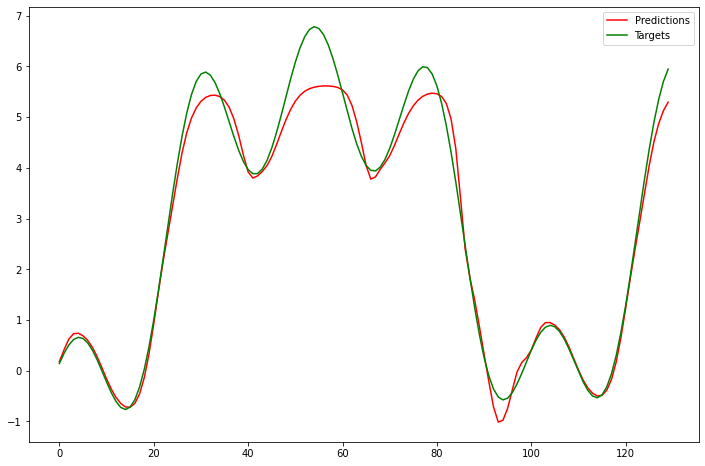

In [13]:
plt.figure(figsize=(12,8))
plt.plot(preds, color='r', label="Predictions")
plt.plot(targets, color='g', label="Targets")
plt.legend()